In [1]:
import Get_data as Gd
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from CAE import Encoder, Decoder, Autoencoder
from torchinfo import summary
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts

In [2]:
# 检查是否有 GPU 可用
if torch.cuda.is_available():
    print("GPU is available")
else:
    print("GPU is not available")

# 检查 GPU 的数量
num_gpus = torch.cuda.device_count()
print(f"Number of GPUs available: {num_gpus}")

# 获取每个 GPU 的名称
for i in range(num_gpus):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")

# 设置默认使用的 GPU 设备
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

GPU is available
Number of GPUs available: 1
GPU 0: NVIDIA RTX A6000
Using device: cuda:0


In [3]:
directory = '/data/Sibo_22Mar2024'
folders = [os.path.join(directory, f, 'hessian_') for f in os.listdir(directory) if f.startswith('case_')]

# CAE

## Create Dataset for CAE

### Use all the case

In [4]:
dataset, length = Gd.get_all_nodes(folders[:-1])

train_np, val_np = train_test_split(dataset, test_size=0.2, shuffle=True)
train_np = np.expand_dims(train_np[:, :, 0], axis=2)
val_np = np.expand_dims(val_np[:, :, 0], axis=2)

In [5]:
preprocessor = Gd.Preprocessor()
preprocessor.fit(train_np)

preprocessed_train_np = preprocessor.transform(train_np)
preprocessed_train_tensor = torch.tensor(preprocessed_train_np, dtype=torch.float).permute(0, 2, 1)
real_train_tensor = torch.tensor(train_np, dtype=torch.float).permute(0, 2, 1)
# train_tensor_set = Gd.MyDataset(preprocessed_train_tensor, real_train_tensor)
train_tensor_set = Gd.MyDataset(real_train_tensor, real_train_tensor)

In [6]:
preprocessed_val_np = preprocessor.transform(val_np)
preprocessed_val_tensor = torch.tensor(preprocessed_val_np, dtype=torch.float).permute(0, 2, 1)
real_val_tensor = torch.tensor(val_np, dtype=torch.float).permute(0, 2, 1)
# val_tensor_set = Gd.MyDataset(preprocessed_val_tensor, real_val_tensor)
val_tensor_set = Gd.MyDataset(real_val_tensor, real_val_tensor)

In [7]:
train_loader = DataLoader(train_tensor_set, batch_size=5, shuffle=True)
val_loader = DataLoader(val_tensor_set, batch_size=1, shuffle=True)

### Test set

In [8]:
test_np, length = Gd.get_all_nodes(folders[-1:])
test_np = np.expand_dims(test_np[:, :, 0], axis=2)

In [9]:
preprocessed_test_np = preprocessor.transform(test_np)
preprocessed_test_tensor = torch.tensor(preprocessed_test_np, dtype=torch.float).permute(0, 2, 1)
real_test_tensor = torch.tensor(test_np, dtype=torch.float).permute(0, 2, 1)
# val_tensor_set = Gd.MyDataset(preprocessed_test_tensor, real_test_tensor)
test_tensor_set = Gd.MyDataset(real_test_tensor, real_test_tensor)

## Model Info

In [10]:
# Create an instance of the model
encoder = Encoder(1, 50)
summary(encoder, input_size=(10, 1, 97149))

Layer (type:depth-idx)                   Output Shape              Param #
Encoder                                  [10, 50]                  --
├─Conv1d: 1-1                            [10, 4, 97149]            36
├─Dropout: 1-2                           [10, 4, 97149]            --
├─MaxPool1d: 1-3                         [10, 4, 19429]            --
├─Conv1d: 1-4                            [10, 4, 19429]            132
├─Dropout: 1-5                           [10, 4, 19429]            --
├─MaxPool1d: 1-6                         [10, 4, 3885]             --
├─Conv1d: 1-7                            [10, 1, 3885]             33
├─LeakyReLU: 1-8                         [10, 1, 3885]             --
├─Dropout: 1-9                           [10, 1, 3885]             --
├─MaxPool1d: 1-10                        [10, 1, 777]              --
├─AdaptiveAvgPool1d: 1-11                [10, 1, 100]              --
├─Flatten: 1-12                          [10, 100]                 --
├─Linear: 1-13

In [11]:
decoder = Decoder(50, 1)
summary(decoder, input_size=(10, 50))

Layer (type:depth-idx)                   Output Shape              Param #
Decoder                                  [10, 1, 97149]            --
├─Linear: 1-1                            [10, 512]                 26,112
├─Upsample: 1-2                          [10, 1, 1024]             --
├─Conv1d: 1-3                            [10, 1, 1018]             9
├─Linear: 1-4                            [10, 1, 97149]            98,994,831
├─Conv1d: 1-5                            [10, 1, 97149]            2
├─LeakyReLU: 1-6                         [10, 1, 97149]            --
Total params: 99,020,954
Trainable params: 99,020,954
Non-trainable params: 0
Total mult-adds (M): 992.24
Input size (MB): 0.00
Forward/backward pass size (MB): 15.67
Params size (MB): 396.08
Estimated Total Size (MB): 411.75

In [12]:
model = Autoencoder(1, 50)
summary(model, input_size=(10, 1, 97149))

Layer (type:depth-idx)                   Output Shape              Param #
Autoencoder                              [10, 1, 97149]            --
├─Encoder: 1-1                           [10, 50]                  --
│    └─Conv1d: 2-1                       [10, 4, 97149]            36
│    └─Dropout: 2-2                      [10, 4, 97149]            --
│    └─MaxPool1d: 2-3                    [10, 4, 19429]            --
│    └─Conv1d: 2-4                       [10, 4, 19429]            132
│    └─Dropout: 2-5                      [10, 4, 19429]            --
│    └─MaxPool1d: 2-6                    [10, 4, 3885]             --
│    └─Conv1d: 2-7                       [10, 1, 3885]             33
│    └─LeakyReLU: 2-8                    [10, 1, 3885]             --
│    └─Dropout: 2-9                      [10, 1, 3885]             --
│    └─MaxPool1d: 2-10                   [10, 1, 777]              --
│    └─AdaptiveAvgPool1d: 2-11           [10, 1, 100]              --
│    └─Flatten

## Train CAE

In [13]:
class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss, self).__init__()
        self.mse = nn.MSELoss()

    def forward(self, y_pred, y_true):
        return torch.sqrt(self.mse(y_pred, y_true))

In [14]:
def train(model, train_loader, test_loader, criterion, optimizer, scheduler, device, preprocessor_test=None, preprocessor=None, epochs=30):
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        recon_train_loss = 0
        for x, real_y in train_loader:
            x = x.to(device)
            optimizer.zero_grad()
            predict= model(x)
            loss = criterion(x, predict)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            if preprocessor is not None:
                predict_np = predict.permute(0, 2, 1).cpu().detach().numpy()
                recon_predict_np = preprocessor.inverse_transform(predict_np)

                recon_predict_tensor = torch.tensor(recon_predict_np, dtype=torch.float).permute(0, 2, 1)
                recon_train_loss += criterion(real_y, recon_predict_tensor)

        scheduler.step()
        train_loss /= len(train_loader)
        recon_train_loss /= len(train_loader)

        model.eval()
        with torch.no_grad():
            val_loss = 0
            recon_test_loss = 0
            for x, real_y in test_loader:
                x = x.to(device)
                predict= model(x)
                val_loss += criterion(x, predict).item()

                #print(criterion(output, sigmoid(data)))
                if preprocessor_test is not None:
                    predict_np = predict.permute(0, 2, 1).cpu().detach().numpy()
                    recon_predict_np = preprocessor_test.inverse_transform(predict_np)
                    recon_predict_tensor = torch.tensor(recon_predict_np, dtype=torch.float).permute(0, 2, 1)
                    recon_test_loss += criterion(real_y, recon_predict_tensor)

            val_loss /= len(test_loader)
            recon_test_loss /= len(test_loader)
        
        print(f'Epoch {epoch + 1}/{epochs}, train Loss: {train_loss}, recon train loss: {recon_train_loss}, val Loss: {val_loss}, recon val Loss: {recon_test_loss}')


In [15]:
model = Autoencoder(1, 50).to(device)
optimizer = optim.Adam(model.parameters())
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=5)

## SCHEDULER

criterion = RMSELoss()

# train(model, train_loader, val_loader, criterion, optimizer, preprocessor, preprocessor,scheduler, device, epochs=20)
train(model, train_loader, val_loader, criterion, optimizer, scheduler, device)
# 保存模型的状态字典
torch.save(model.state_dict(), 'CAE.pth')

Epoch 1/30, train Loss: 5.221778402040744, recon train loss: 0.0, val Loss: 3.892792237421562, recon val Loss: 0.0
Epoch 2/30, train Loss: 3.5384452864527702, recon train loss: 0.0, val Loss: 3.7212871543806174, recon val Loss: 0.0
Epoch 3/30, train Loss: 2.7371320128440857, recon train loss: 0.0, val Loss: 2.95104548468672, recon val Loss: 0.0
Epoch 4/30, train Loss: 2.0781288791833252, recon train loss: 0.0, val Loss: 2.878947282762363, recon val Loss: 0.0
Epoch 5/30, train Loss: 1.7252968718008748, recon train loss: 0.0, val Loss: 2.7519171516186205, recon val Loss: 0.0
Epoch 6/30, train Loss: 2.2824696401969113, recon train loss: 0.0, val Loss: 2.780192612368485, recon val Loss: 0.0
Epoch 7/30, train Loss: 1.9473101192250335, recon train loss: 0.0, val Loss: 3.4512885881395174, recon val Loss: 0.0
Epoch 8/30, train Loss: 1.6342871329779256, recon train loss: 0.0, val Loss: 2.4769375982983357, recon val Loss: 0.0
Epoch 9/30, train Loss: 1.3275130513798574, recon train loss: 0.0, val

## Result

In [16]:
def draw_pic(model, real_x, x, real_output, preprocessor, coords):
    output = model(x.to(device))

    # output.to("cpu")
    output_array = output.cpu().detach().numpy() # [5, 1, 97149]
    recon_output = preprocessor.inverse_transform(output_array)

    fig1, axs = plt.subplots(1, 5, figsize=(30, 6))
    for i in range(len(axs)):
        axs[i].scatter(coords[:,0],coords[:,1],s = 5, c=real_x[i, :, 0], cmap='bwr')
        axs[i].set_title(f'Input {i+1}')
    plt.show()
    plt.close()

    fig2, axs = plt.subplots(1, 5, figsize=(30, 6))
    for i in range(len(axs)):
        axs[i].scatter(coords[:,0],coords[:,1],s = 5, c=recon_output[i, 0, :], cmap='bwr')
        axs[i].set_title(f'Predict {i+1}')
    plt.show()
    plt.close()

    fig3, axs = plt.subplots(1, 5, figsize=(30, 6))
    for i in range(len(axs)):
        axs[i].scatter(coords[:,0],coords[:,1],s = 5, c=real_output[i, :, 0], cmap='bwr')
        axs[i].set_title(f'Real output {i+1}')
    plt.show()
    plt.close()

In [17]:
xyfile = "/data/Sibo_22Mar2024/case_0/hessian_/xy_coords.npy"
xycoords_check = np.load(xyfile)

In [18]:
model = Autoencoder(1, 50)
# 加载保存的状态字典
state_dict = torch.load('CAE.pth')
model.load_state_dict(state_dict)
model.to(device)

Autoencoder(
  (encoder): Encoder(
    (conv1): Conv1d(1, 4, kernel_size=(8,), stride=(1,), padding=same, dilation=(2,))
    (dropout1): Dropout(p=0.1, inplace=False)
    (pool1): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv1d(4, 4, kernel_size=(8,), stride=(1,), padding=same, dilation=(2,))
    (dropout2): Dropout(p=0.1, inplace=False)
    (pool2): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
    (conv3): Conv1d(4, 1, kernel_size=(8,), stride=(1,), padding=same, dilation=(2,))
    (leaky_relu): LeakyReLU(negative_slope=0.3)
    (dropout3): Dropout(p=0.1, inplace=False)
    (pool3): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
    (avg_pool): AdaptiveAvgPool1d(output_size=100)
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (dense): Linear(in_features=100, out_features=50, bias=True)
  )
  (decoder): Decoder(
    (dense1): Linear(in_features=50, out_features=512, bias=True)
 

In [19]:
real_x = test_np[0:5]
x = torch.tensor(preprocessor.transform(real_x), dtype=torch.float).permute(0, 2, 1)
real_output = real_x

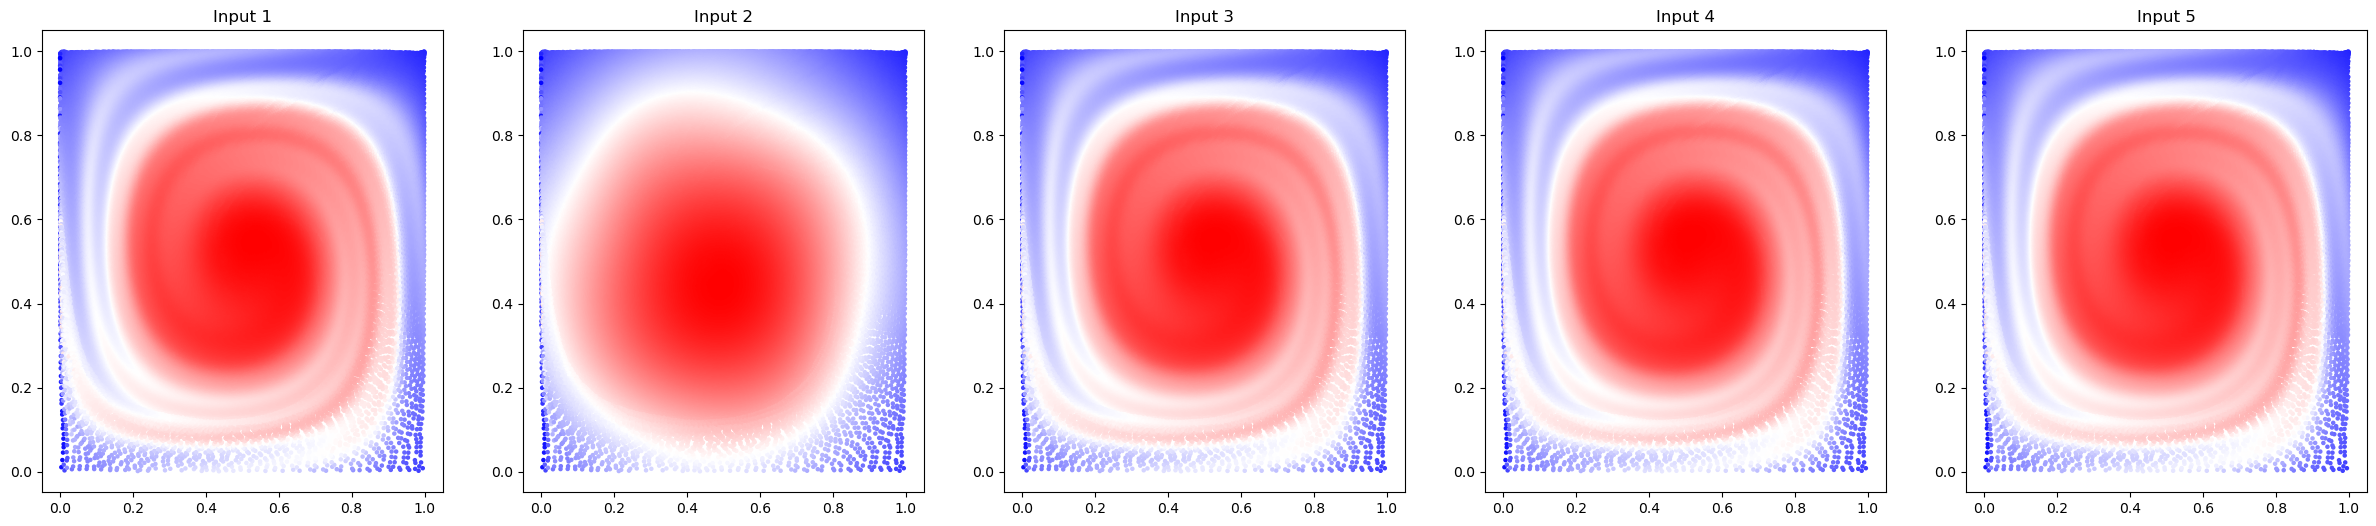

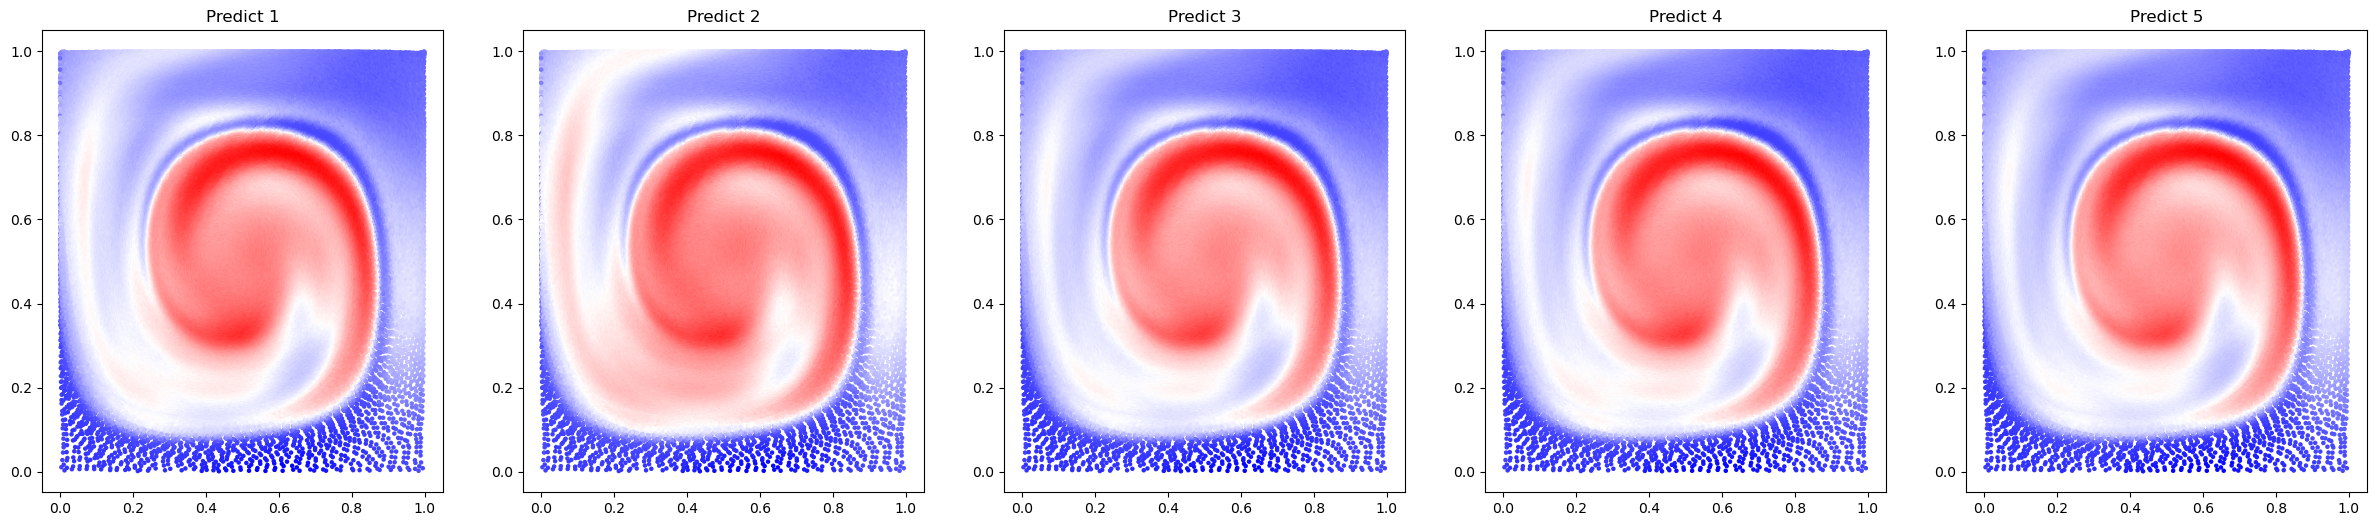

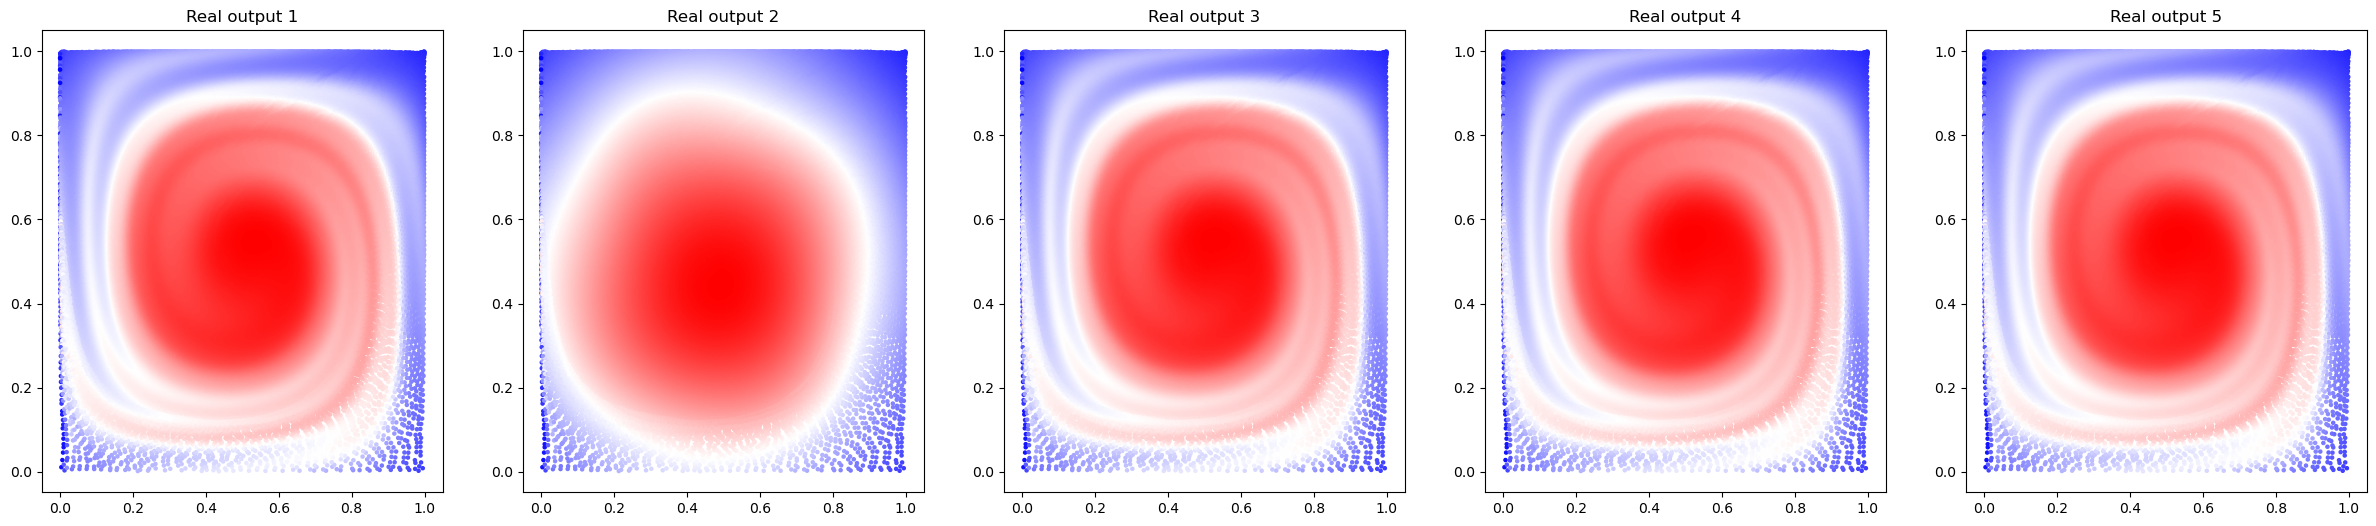

In [20]:
draw_pic(model, real_x, x, real_output, preprocessor, xycoords_check)

# Seq2Seq

## Create Dataset for Seq2Seq

In [21]:
CAE = Autoencoder(1, 50)
# 加载保存的状态字典
state_dict = torch.load('CAE.pth')
CAE.load_state_dict(state_dict)
CAE.to(device)

Autoencoder(
  (encoder): Encoder(
    (conv1): Conv1d(1, 4, kernel_size=(8,), stride=(1,), padding=same, dilation=(2,))
    (dropout1): Dropout(p=0.1, inplace=False)
    (pool1): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv1d(4, 4, kernel_size=(8,), stride=(1,), padding=same, dilation=(2,))
    (dropout2): Dropout(p=0.1, inplace=False)
    (pool2): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
    (conv3): Conv1d(4, 1, kernel_size=(8,), stride=(1,), padding=same, dilation=(2,))
    (leaky_relu): LeakyReLU(negative_slope=0.3)
    (dropout3): Dropout(p=0.1, inplace=False)
    (pool3): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
    (avg_pool): AdaptiveAvgPool1d(output_size=100)
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (dense): Linear(in_features=100, out_features=50, bias=True)
  )
  (decoder): Decoder(
    (dense1): Linear(in_features=50, out_features=512, bias=True)
 

### Trainset

In [22]:
# train_data, length = Gd.get_all_nodes(folders[:-2]) # last two case are used to test
# train_data = np.expand_dims(train_data[:, :, 0], axis=2)
# preprocessed_train_data = preprocessor.transform(train_data)
# preprocessed_train_tensor = torch.tensor(preprocessed_train_data, dtype=torch.float).permute(0, 2, 1).to(device)

# encoded_train_data = CAE.encoder(preprocessed_train_tensor)
# encoded_train_data_np = encoded_train_data.cpu().detach().numpy()
# encoded_seq_train_data = Gd.segment_data(encoded_train_data_np, length, 10, 5)
# np.random.shuffle(encoded_seq_train_data)

In [23]:
# encoded_seq_train_tensor = torch.tensor(encoded_seq_train_data, dtype=torch.float)
# train_x_seq = encoded_seq_train_tensor[:, :5, :]
# train_y_seq = encoded_seq_train_tensor[:, 5:, :]

# train_set_seq = Gd.MyDataset(train_x_seq, train_y_seq)
# train_loader_seq = DataLoader(train_set_seq, batch_size=1, shuffle=True)

In [24]:
# train_x_seq.shape

### Testset

In [25]:
# test_data, length = Gd.get_all_nodes(folders[-2:]) # last two case are used to test
# test_data = np.expand_dims(test_data[:, :, 0], axis=2)
# preprocessed_test_data = preprocessor.transform(test_data)
# preprocessed_test_tensor = torch.tensor(preprocessed_test_data, dtype=torch.float).permute(0, 2, 1).to(device)

# encoded_test_data = CAE.encoder(preprocessed_test_tensor)
# encoded_test_data_np = encoded_test_data.cpu().detach().numpy()
# encoded_seq_test_data = Gd.segment_data(encoded_test_data_np, length, 10, 5)
# np.random.shuffle(encoded_seq_test_data)

In [26]:
# encoded_seq_test_tensor = torch.tensor(encoded_seq_test_data, dtype=torch.float)
# test_x_seq = encoded_seq_test_tensor[:, :5, :]
# test_y_seq = encoded_seq_test_tensor[:, 5:, :]

# test_set_seq = Gd.MyDataset(test_x_seq, test_y_seq)
# test_loader_seq = DataLoader(test_set_seq, batch_size=5, shuffle=True)

### Another way to create dataset

In [27]:
data, length = Gd.get_all_nodes(folders[:-2]) # last two case are used to test
data = np.expand_dims(data[:, :, 0], axis=2)
preprocessed_data = preprocessor.transform(data)
preprocessed_tensor = torch.tensor(preprocessed_data, dtype=torch.float).permute(0, 2, 1).to(device)

encoded_data = CAE.encoder(preprocessed_tensor)
encoded_data_np = encoded_data.cpu().detach().numpy()
encoded_seq_data = Gd.segment_data(encoded_data_np, length, 10, 5)

encoded_seq_train_np, encoded_seq_test_np = train_test_split(encoded_seq_data, test_size=0.2, shuffle=True)

OutOfMemoryError: CUDA out of memory. Tried to allocate 1.62 GiB. GPU 

: 

In [ ]:
encoded_seq_train_np.shape

(425, 10, 50)

In [ ]:
encoded_seq_train_tensor = torch.tensor(encoded_seq_train_np, dtype=torch.float)
encoded_seq_test_tensor = torch.tensor(encoded_seq_test_np, dtype=torch.float)

train_x_seq = encoded_seq_train_tensor[:, :5, :]
train_y_seq = encoded_seq_train_tensor[:, 5:, :]

test_x_seq = encoded_seq_test_tensor[:, :5, :]
test_y_seq = encoded_seq_test_tensor[:, 5:, :]

train_set_seq = Gd.MyDataset(train_x_seq, train_y_seq)
train_loader_seq = DataLoader(train_set_seq, batch_size=1, shuffle=True)

test_set_seq = Gd.MyDataset(test_x_seq, test_y_seq)
test_loader_seq = DataLoader(test_set_seq, batch_size=5, shuffle=True)

## Model Info

In [ ]:
import Seq2Seq

In [ ]:
encoder = Seq2Seq.Encoder(50, 100)
summary(encoder, input_size=(5, 5, 50))

Layer (type:depth-idx)                   Output Shape              Param #
Encoder                                  [5, 100]                  --
├─Linear: 1-1                            [5, 100]                  5,100
├─Linear: 1-2                            [5, 100]                  10,100
├─Sigmoid: 1-3                           [5, 100]                  --
├─Linear: 1-4                            [5, 100]                  5,100
├─Linear: 1-5                            [5, 100]                  10,100
├─Sigmoid: 1-6                           [5, 100]                  --
├─Linear: 1-7                            [5, 100]                  5,100
├─Linear: 1-8                            [5, 100]                  10,100
├─Sigmoid: 1-9                           [5, 100]                  --
├─Linear: 1-10                           [5, 100]                  5,100
├─Linear: 1-11                           [5, 100]                  10,100
├─Linear: 1-12                           [5, 100]        

In [ ]:
decoder = Seq2Seq.Decoder(100, 50, 5)

summary(decoder, input_size=((5, 100), (5, 100), (5, 100)))

Layer (type:depth-idx)                   Output Shape              Param #
Decoder                                  [5, 5, 50]                --
├─Linear: 1-1                            [5, 50]                   5,050
├─Linear: 1-2                            [5, 50]                   5,050
├─Linear: 1-3                            [5, 50]                   5,050
├─Linear: 1-4                            [5, 50]                   2,550
├─Sigmoid: 1-5                           [5, 50]                   --
├─Linear: 1-6                            [5, 50]                   5,050
├─Linear: 1-7                            [5, 50]                   2,550
├─Sigmoid: 1-8                           [5, 50]                   --
├─Linear: 1-9                            [5, 50]                   5,050
├─Linear: 1-10                           [5, 50]                   2,550
├─Sigmoid: 1-11                          [5, 50]                   --
├─Linear: 1-12                           [5, 50]             

In [ ]:
model = Seq2Seq.Seq2Seq(50, 100, 50, 5)
summary(model, input_size=(5, 5, 50))

Layer (type:depth-idx)                   Output Shape              Param #
Seq2Seq                                  [5, 5, 50]                --
├─Encoder: 1-1                           [5, 100]                  --
│    └─Linear: 2-1                       [5, 100]                  5,100
│    └─Linear: 2-2                       [5, 100]                  10,100
│    └─Sigmoid: 2-3                      [5, 100]                  --
│    └─Linear: 2-4                       [5, 100]                  5,100
│    └─Linear: 2-5                       [5, 100]                  10,100
│    └─Sigmoid: 2-6                      [5, 100]                  --
│    └─Linear: 2-7                       [5, 100]                  5,100
│    └─Linear: 2-8                       [5, 100]                  10,100
│    └─Sigmoid: 2-9                      [5, 100]                  --
│    └─Linear: 2-10                      [5, 100]                  5,100
│    └─Linear: 2-11                      [5, 100]            

## Train Seq2Seq

In [ ]:
class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss, self).__init__()
        self.mse = nn.MSELoss()

    def forward(self, y_pred, y_true):
        return torch.sqrt(self.mse(y_pred, y_true))

In [ ]:
def train(model, train_loader, test_loader, criterion, optimizer, device, epochs=30):
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            predict= model(x)
            loss = criterion(y, predict)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)

        model.eval()
        with torch.no_grad():
            val_loss = 0
            for x, y in test_loader:
                x, y = x.to(device), y.to(device)
                predict= model(x)
                val_loss += criterion(y, predict).item()


            val_loss /= len(test_loader)
        
        print(f'Epoch {epoch + 1}/{epochs}, train Loss: {train_loss}, val Loss: {val_loss}')


In [ ]:
model = Seq2Seq.Seq2Seq(50, 100, 50, 5).to(device)
optimizer = optim.Adam(model.parameters())
criterion = RMSELoss()

train(model, train_loader_seq, test_loader_seq, criterion, optimizer, device)
# 保存模型的状态字典
torch.save(model.state_dict(), 'Seq2Seq.pth')

Epoch 1/30, train Loss: 0.0726959657603327, val Loss: 0.06502218053422192
Epoch 2/30, train Loss: 0.060029608859297104, val Loss: 0.0629858576099981
Epoch 3/30, train Loss: 0.057495487794718324, val Loss: 0.05950107239186764
Epoch 4/30, train Loss: 0.056404042857534746, val Loss: 0.06197186661037532
Epoch 5/30, train Loss: 0.0554569935426116, val Loss: 0.05894105729054321
Epoch 6/30, train Loss: 0.05506003499031067, val Loss: 0.05836305365135724
Epoch 7/30, train Loss: 0.05460802697083529, val Loss: 0.05777451641518961
Epoch 8/30, train Loss: 0.05439025111277314, val Loss: 0.057143538470634005
Epoch 9/30, train Loss: 0.05401578040903105, val Loss: 0.059614022939719936
Epoch 10/30, train Loss: 0.05379184739335495, val Loss: 0.0581247400153767
Epoch 11/30, train Loss: 0.053434514440596104, val Loss: 0.05948581749742681
Epoch 12/30, train Loss: 0.05338997869587996, val Loss: 0.05798006591133096
Epoch 13/30, train Loss: 0.05314161612487891, val Loss: 0.059954498979178344
Epoch 14/30, train

KeyboardInterrupt: 

# Validation

In [ ]:
CAE = Autoencoder(1, 50)
# 加载保存的状态字典
state_dict = torch.load('CAE.pth')
CAE.load_state_dict(state_dict)
CAE.to(device)

Seq2Seq = Seq2Seq.Seq2Seq(50, 100, 50, 5)
# 加载保存的状态字典
state_dict = torch.load('Seq2Seq.pth')
Seq2Seq.load_state_dict(state_dict)
Seq2Seq.to(device)

Seq2Seq(
  (encoder): Encoder(
    (sigmoid): Sigmoid()
    (W_xi): Linear(in_features=50, out_features=100, bias=True)
    (W_hi): Linear(in_features=100, out_features=100, bias=True)
    (W_xf): Linear(in_features=50, out_features=100, bias=True)
    (W_hf): Linear(in_features=100, out_features=100, bias=True)
    (W_xo): Linear(in_features=50, out_features=100, bias=True)
    (W_ho): Linear(in_features=100, out_features=100, bias=True)
    (W_xc): Linear(in_features=50, out_features=100, bias=True)
    (W_hc): Linear(in_features=100, out_features=100, bias=True)
  )
  (decoder): Decoder(
    (sigmoid): Sigmoid()
    (W_xi): Linear(in_features=100, out_features=50, bias=True)
    (W_hi): Linear(in_features=50, out_features=50, bias=True)
    (W_xf): Linear(in_features=100, out_features=50, bias=True)
    (W_hf): Linear(in_features=50, out_features=50, bias=True)
    (W_xo): Linear(in_features=100, out_features=50, bias=True)
    (W_ho): Linear(in_features=50, out_features=50, bias=Tr

## Get data

In [ ]:
val_data, length = Gd.get_all_nodes(folders[-2:])
val_data = np.expand_dims(val_data[:, :, 0], axis=2)




In [ ]:
preprocessed_tensor = torch.tensor(preprocessed_data, dtype=torch.float).permute(0, 2, 1).to(device)

encoded_data = CAE.encoder(preprocessed_tensor)
encoded_data_np = encoded_data.cpu().detach().numpy()
encoded_seq_data = Gd.segment_data(encoded_data_np, length, 10, 5)

encoded_seq_train_np, encoded_seq_test_np = train_test_split(encoded_seq_data, test_size=0.2, shuffle=True)

In [ ]:
val_data.shape

(200, 97149, 1)